In [ ]:
'''import numpy as np
from adapt.instance_based import TrAdaBoostR2
import json
from scikeras.wrappers import KerasRegressor
from src.model import CNN
from src.util import timestamp
import keras
from tqdm import tqdm
import joblib
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, concatenate
from adapt.instance_based import TrAdaBoostR2
from tensorflow.keras.callbacks import TensorBoard
import json
from src.model import CNN
from src.util import timestamp
from IPython import display  # WICHTIG für Jupyter Live-Update
import matplotlib.pyplot as plt
import keras
from src.execution import CNNValidationExecution 
from src.data import NPY
import pandas as pd
import numpy as np
from pandasgui import show
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Lambda, Concatenate
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.layers import Layer'''
import json
import os

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython import display  # WICHTIG für Jupyter Live-Update
from pandasgui import show
from tqdm import tqdm
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.callbacks import CSVLogger, TensorBoard
from tensorflow.keras.layers import Concatenate, Dense, Lambda, Layer, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import register_keras_serializable

from adapt.instance_based import TrAdaBoostR2
from scikeras.wrappers import KerasRegressor

from src.data import NPY
from src.execution import CNNValidationExecution
from src.execution import WindowSplittingExecution
from src.model import CNN
from src.util import timestamp


Domainadaptation mit TradaBoostR2 aus der Adapt Libary
Erste Version, wenns läuft dann später in den Klassen die einzelnen Methoden ergänzen

---
## **Trainingsdaten erzeugen**
Da die Zuordnung der Datenmengen über die Anzahl der Versuche läuft, wird hier nur der Belchsplit durchgeführt, es wird eine bestimmte Anzahl an Blechen gewählt. 

- Trainingsdaten aus den Simulationsdaten werden wie gehabt erzeugt
- Target Domain Daten werden aus den Raldaten erzeugt.   

Simulationsdaten: Blechsplit

In [80]:
#DATA: str = "assets/synthetic-data.csv"
DATA: str = "assets/stationary_data_250405/sim_data_preprocessed.csv"
VALIDATION_SPLIT: bool = True # If the data should also be splitted into a validation set?
TEST_SIZE: float = 0.2
BATCH_SPLIT: bool = False
BATCHSIZE: int = 326 # real-data: 1800, synthetic-data: 326
SEED: int = 69 # Seed for random state -> Split with same seed and data will always result in the same split
INTERPOLATION: bool = False
WINDOWSIZE: int = 10
SEP: str = ";" # Separator of the csv file
DECIMAL: str = "." # Decimal separator of the csv file


WindowSplittingExecution.execute(DATA, 
                                 BATCH_SPLIT, 
                                 VALIDATION_SPLIT, 
                                 TEST_SIZE, 
                                 SEED, 
                                 BATCHSIZE, 
                                 INTERPOLATION, 
                                 WINDOWSIZE, 
                                 SEP, 
                                 DECIMAL)



Anzahl an Bleche in der Gesamtmatrix 178
(5625, 1, 3)
Shape für die Features der gesamten Trainingsdaten, also im Falle einer Interpolation mit allen Daten (44998, 10, 11)
Shape für die Features der gesamten Testdaten, also im Falle einer Interpolation mit allen Daten (5625, 10, 11) 
Shape für die Labels der gesamten Trainingsdaten, also im Falle einer Interpolation mit allen Daten (44998, 1, 3)
Shape für die Labels der gesamten Testdaten, also im Falle einer Interpolation mit allen Daten (5625, 1, 3)
Data saved in build\window_split\sim_data_preprocessed\1743966827


Realdaten Blechsplit (`Train_Test_Split = 2`):
- Die Daten trennen in A % Trainingsdaten für den TradaBoostR2 und B % Testdaten
--> Solche Auftielung mti den Vorhandneen Methoden leichter umzusetzen als über exakte Anzahl der Bleche
- Die Domain Adaptation wird auf dem A % Testdaten durchgeführt
- Testen erfolgt auf dem Testdatensatz
- Die Größenverhältnisse der Datensätze werden über die Variable  `size` eingestellt
- `size = 0.9` so werden 10 % der Bleche in das TradaBoost DaomainAdaptaion gegeben, die restlichen 90 % der Daten werden zum Kontrollieren verwndet  

In [75]:
#DATA: str = "assets/real-data.csv"
DATA: str = "assets/stationary_data_250405/experiment-data-subset.csv"
VALIDATION_SPLIT: bool = True # If the data should also be splitted into a validation set?
TEST_SIZE: float = 0.9
BATCH_SPLIT: bool = False
BATCHSIZE: int = 1800 # real-data: 1800, synthetic-data: 326
SEED: int = 69 # Seed for random state -> Split with same seed and data will always result in the same split
INTERPOLATION: bool = False
WINDOWSIZE: int = 10
SEP: str = ";" # Separator of the csv file
DECIMAL: str = "," # Decimal separator of the csv file

WindowSplittingExecution.execute(DATA, 
                                 BATCH_SPLIT, 
                                 VALIDATION_SPLIT, 
                                 TEST_SIZE, 
                                 SEED, 
                                 BATCHSIZE, 
                                 INTERPOLATION, 
                                 WINDOWSIZE, 
                                 SEP, 
                                 DECIMAL)



Anzahl an Bleche in der Gesamtmatrix 130
(104715, 1, 3)
Shape für die Features der gesamten Trainingsdaten, also im Falle einer Interpolation mit allen Daten (23270, 10, 11)
Shape für die Features der gesamten Testdaten, also im Falle einer Interpolation mit allen Daten (104715, 10, 11) 
Shape für die Labels der gesamten Trainingsdaten, also im Falle einer Interpolation mit allen Daten (23270, 1, 3)
Shape für die Labels der gesamten Testdaten, also im Falle einer Interpolation mit allen Daten (104715, 1, 3)
Data saved in build\window_split\experiment-data-subset\1743966491


## **Kontrolle der Verteilungen**
Verglichen werden die Verteilungen der Inputs und Outputs vor dem Skalierung und danach
Problem: Die Daten der Targetdomain und der Sourcdomain werdne mit unterschiedlichen Scalern skaliert, die skalierten Daten leigen immer übereinander, da mit min max scaliert wird 

In [76]:
dateipfad_femDaten="build\\window_split\\sim_data_preprocessed\\1743966345"
dateipfad_realDaten="build\\window_split\\experiment-data-subset\\1743966491"	

def plotAllHistOfFIle(file_name):
    # Lade die Daten aus beiden Ordnern
    fem_path = os.path.join(dateipfad_femDaten, file_name)
    real_path = os.path.join(dateipfad_realDaten, file_name)

    # Daten als numpy-Array laden
    fem_data = np.load(fem_path)
    real_data = np.load(real_path)
    fem_data = fem_data.reshape(-1, fem_data.shape[2])  # Shape: (287560, 11)
    real_data = real_data.reshape(-1, real_data.shape[2])  # Shape: (254180, 11)
    # Anzahl der Features (Spalten)
    num_features = fem_data.shape[1]
    print(fem_data.shape)
    print(real_data.shape)
    bins = 50  # Anzahl der Bins für die Histogramme


    # Anzahl der Spalten pro Zeile
    cols = 4
    rows = (num_features + cols - 1) // cols  # Rundet auf, falls nicht durch 4 teilbar

    # Plots erstellen
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    axes = axes.flatten()  # 2D Array in 1D umwandeln für einfachere Iteration

    for i in range(num_features):
        ax = axes[i]
        sns.histplot(fem_data[:, i], bins=bins, kde=True, ax=axes[i], color="blue", label="Simulation", stat="density", alpha=0.6)
        sns.histplot(real_data[:, i], bins=bins, kde=True, ax=axes[i], color="orange", label="Realdaten", stat="density", alpha=0.6)
        ax.set_title(f"Feature {i+1}")
        ax.set_xlabel("Wert")
        ax.set_ylabel("Dichte")
        ax.legend()

    # Leere Subplots deaktivieren, falls es weniger als 4*n Features gibt
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Datei laden



(281240, 11)
(232700, 11)


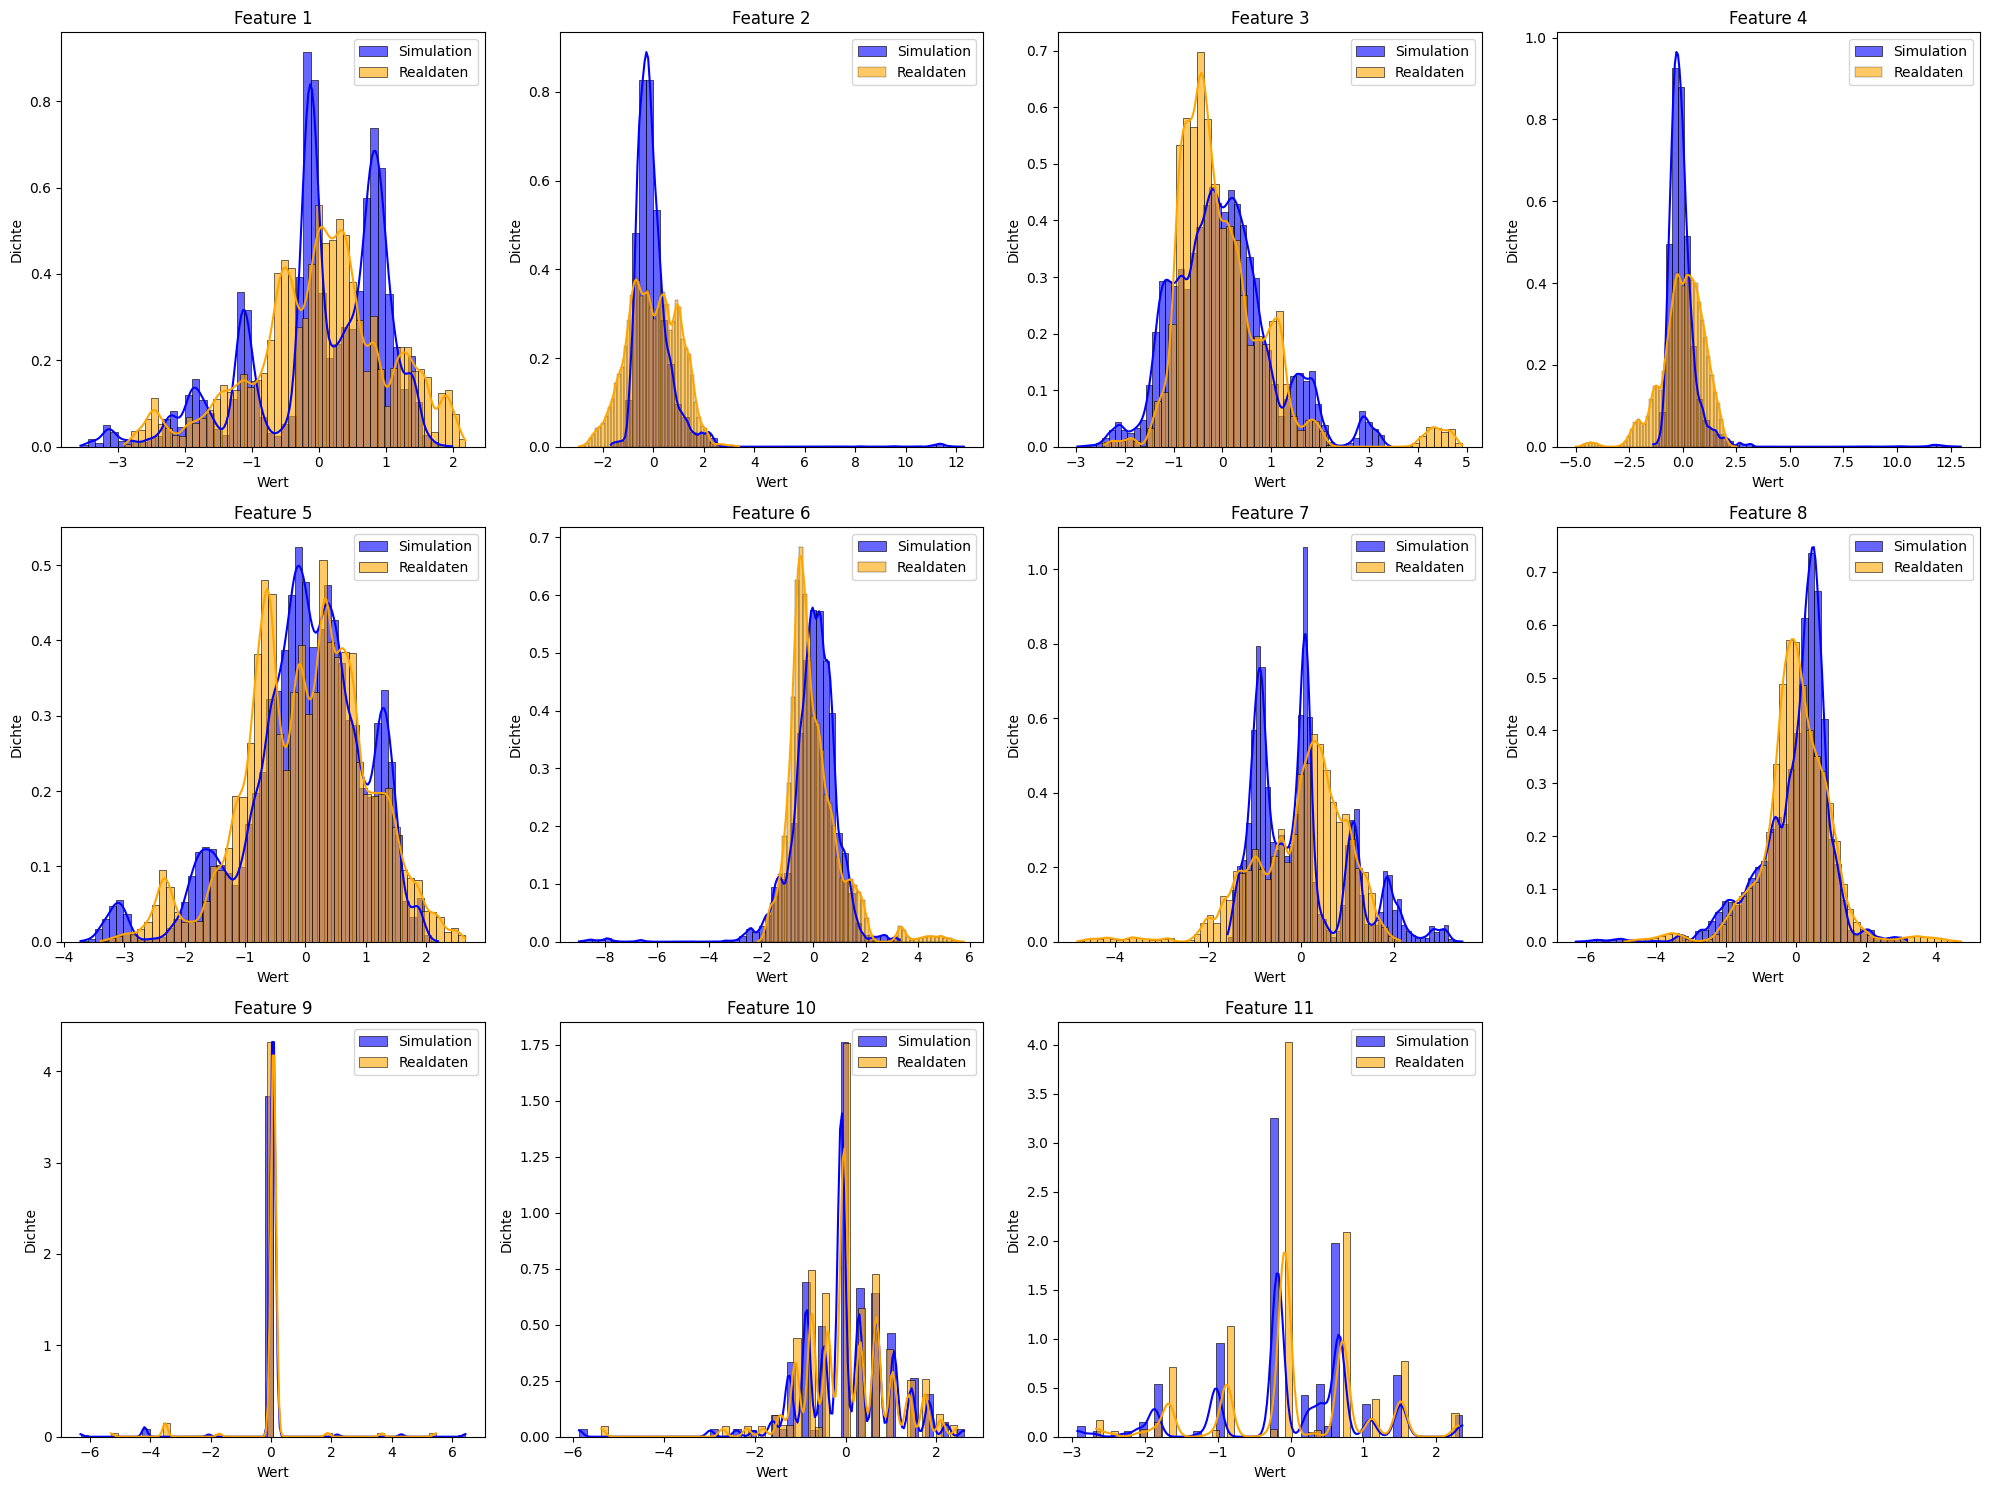

In [77]:
plotAllHistOfFIle("x-train-scaled.npy")

(28124, 3)
(23270, 3)


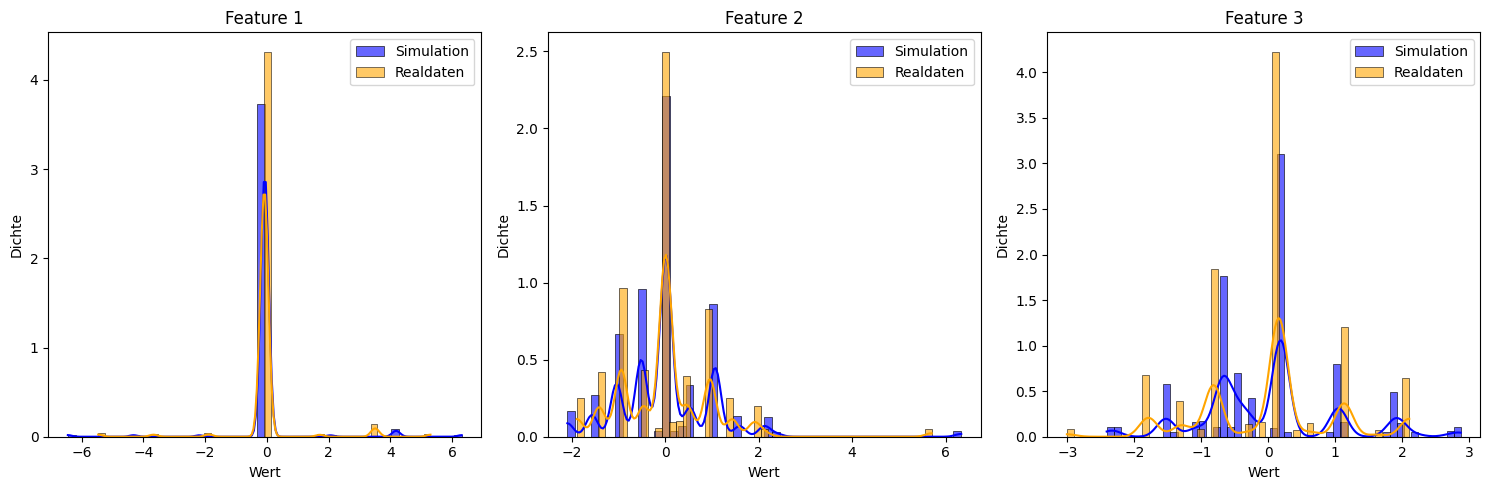

In [78]:
plotAllHistOfFIle("y-train-scaled.npy")

## **TradaBoostR2**
- Early stopping und Valiadation enthalten
- Sonsten erstmal Parameter günsitg einstellen, sodass Effekt sichtbar wird
- Modell umschrieben mit neuer Sparse Layer, eine Layer fasst die Outputs von zuvor zusammen 
    - Die Letze Layer wird nun nur sparse besetzt und ist nicht trainierbar
    - Outputs werden direkt in diese Layer weitergegeben, ist so ne Eigenheit von TradaBoostR2, kann nur auf einem Output arbeiten

In [79]:
# Validation data muss mit erzeugt werden
DATA: str = "assets/stationary_data_250405/experiment-data-subset.csv"
VALIDATION_SPLIT: bool = True # If the data should also be splitted into a validation set?
TEST_SIZE: float = 0.9
BATCH_SPLIT: bool = False
BATCHSIZE: int = 326 # real-data: 1800, synthetic-data: 326
SEED: int = 69 # Seed for random state -> Split with same seed and data will always result in the same split
INTERPOLATION: bool = False
WINDOWSIZE: int = 10
SEP: str = ";" # Separator of the csv file
DECIMAL: str = "." # Decimal separator of the csv file


WindowSplittingExecution.execute(DATA, 
                                 BATCH_SPLIT, 
                                 VALIDATION_SPLIT, 
                                 TEST_SIZE, 
                                 SEED, 
                                 BATCHSIZE, 
                                 INTERPOLATION, 
                                 WINDOWSIZE, 
                                 SEP, 
                                 DECIMAL)

Anzahl an Bleche in der Gesamtmatrix 717
(101958, 1, 3)
Shape für die Features der gesamten Trainingsdaten, also im Falle einer Interpolation mit allen Daten (22657, 10, 11)
Shape für die Features der gesamten Testdaten, also im Falle einer Interpolation mit allen Daten (101958, 10, 11) 
Shape für die Labels der gesamten Trainingsdaten, also im Falle einer Interpolation mit allen Daten (22657, 1, 3)
Shape für die Labels der gesamten Testdaten, also im Falle einer Interpolation mit allen Daten (101958, 1, 3)
Data saved in build\window_split\experiment-data-subset\1743966820


In [ ]:
@register_keras_serializable(package="custom_layers")
class SparseStackLayer(Layer):
    def __init__(self, **kwargs):
        super(SparseStackLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Kombiniert Liste von Tensoren (z. B. [batch, 1], [batch, 1], [batch, 1])
        # zu einem Tensor mit Shape (batch, 3)
        return tf.concat(inputs, axis=-1)
class LivePlotCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.history = {"loss": [], "val_loss": []}
        #self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        self.history["loss"].append(logs.get("loss", 0))
        self.history["val_loss"].append(logs.get("val_loss", 0))

    def on_train_end(self, logs=None):
        logs = logs or {}
        self.history["loss"].append(logs.get("loss", 0))
        self.history["val_loss"].append(logs.get("val_loss", 0))

        plt.figure(figsize=(6, 4))
        epochs = list(range(1, len(self.history["loss"]) + 1))

        plt.plot(epochs, self.history["loss"], label="Trainingsverlust (Loss)", color="blue", marker="o")
        plt.plot(epochs, self.history["val_loss"], label="Validierungsverlust (Loss)", color="red", linestyle="dashed", marker="o")

        plt.xlabel("Epoche")
        plt.ylabel("Loss")
        plt.title("Training vs. Validierung")
        plt.grid(True)
        plt.legend()
        
        #if self.save_path:
        #    plt.savefig(self.save_path)
        
        display.display(plt.gcf())

def domainAdapt_tradaBoostR2_earlystopping(cnn_wrapped,n_estimators_tradaBoostR2,
                                           X_source_scaled,y_source_scaled,
                                           X_target_scaled,y_target_scaled,
                                           X_source_scaled_Test,y_source_scaled_Test,
                                           save_folder, save_filename                    
                                           ):
    
    training_progress = []
    tradaboost_model = TrAdaBoostR2(
        estimator=cnn_wrapped,  # CNN als Basis-Regressor
        n_estimators=n_estimators_tradaBoostR2,  # Anzahl der Boosting-Iterationen
        verbose=1
    )
    
    y_source_scaled=np.squeeze(y_source_scaled)
    y_target_scaled=np.squeeze(y_target_scaled)

    print("\n Training mit TrAdaBoostR2 gestartet \n")
    print(f"save_folder = {save_folder}")
    print(f"")
    #tqdm mach interen Schlaife von TradaBoostR2 zu externer schleife um Trainingsprozess zu verfolgen
    with tqdm(total=tradaboost_model.n_estimators, desc="TrAdaBoostR2 Fortschritt") as pbar:
        for i in range(tradaboost_model.n_estimators):
            #Fitten einer Iteration von TradaBoostR2
            tradaboost_model.fit(X_source_scaled, y_source_scaled,
                                 X_target_scaled, y_target_scaled,
                                 validation_data=(X_source_scaled_Test,y_source_scaled_Test))
            #Modelle zwischenspeichern für evaluierung des Trainings
            keras_model = tradaboost_model.estimators_[-1].model_
            keras_model.save(os.path.join(save_folder, f"tradaboost_model_iter_{i}.h5"))
            #Trainingsprocess speichern
            checkpoint_data = {
                "iteration": i + 1,
                "loss": keras_model.evaluate(X_source_scaled_Test, y_source_scaled_Test, verbose=0),
                "estimator_count": len(tradaboost_model.estimators_),
                "weights": tradaboost_model.estimator_weights_,
                "errors": tradaboost_model.estimator_errors_,
            }
            training_progress.append(checkpoint_data)
            #Updaten des Modellsfortschritts 
            pbar.update(1)
    print("\n Training mit TrAdaBoostR2 beendet \n")
    
    json_path = os.path.join(save_folder, f"tradaBoostR2_trainingProgress.json")
    with open(json_path, 'w') as json_file:
        json.dump(training_progress, json_file, indent=4, default=str)
    
    # Extrahiertes Modell nach dem Training speichern
    trained_model = tradaboost_model.estimators_[-1]  # Letzter trainierter Estimator

    # Modell speichern
    trained_model.model_.save(os.path.join(save_folder, f"{save_filename}.h5"))

def execute_tradaBoostR2_training(dateipfad_femDaten,dateipfad_realDaten,model_file,save_folder,save_filename, learning_rate,
                                  epochs,n_estimators_tradaBoostR2=5,batch_size=32,patience=3):
    #Simulationsdaten      
    X_source_scaled = NPY.from_file(dateipfad_femDaten + "x-train-scaled.npy").array
    y_source_scaled = NPY.from_file(dateipfad_femDaten + "y-train-scaled.npy").array
    X_source_scaled_Test = NPY.from_file(dateipfad_femDaten + "x-validate-scaled.npy").array
    y_source_scaled_Test = NPY.from_file(dateipfad_femDaten + "y-validate-scaled.npy").array
    # Realdaten
    X_target_scaled = NPY.from_file(dateipfad_realDaten + "x-train-scaled.npy").array
    y_target_scaled = NPY.from_file(dateipfad_realDaten + "y-train-scaled.npy").array

    #Modell erstellen
    cnn = CNN.from_file(model_file)
    outputs = cnn.model.outputs
    combined_output = SparseStackLayer(name="sparse_output")(outputs)
    new_model = tf.keras.Model(inputs=cnn.model.inputs, outputs=combined_output, name="extended_model")
    live_plot_callback = LivePlotCallback()

    new_model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                    loss="mean_absolute_error", 
                    metrics=["mae"])#TODO Bruache ich diese Zeile?

    early_stopping =keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    #csv_logger = CSVLogger(filename=os.path.join(save_folder, "training_log.csv"), separator=",", append=False)
    csv_logger = CSVLogger(filename=os.path.join(save_folder, "training_log.csv"), separator=",", append=True)
    cnn_wrapped = KerasRegressor(model=new_model, epochs=epochs, batch_size=batch_size, verbose=1,callbacks=[early_stopping,csv_logger,live_plot_callback])
    
    #Dokumentation des Training smit Tradaboost
    initial_training_setup = {
                "Speicherorte": {
                "Modell": model_file,
                "Simulationsdaten": dateipfad_femDaten,
                "Realdaten": dateipfad_realDaten,
                "save_folder": save_folder,
                "save_filename": save_filename,
                },
                "Training Parameter": {
                 
                "Optimizer": {
                    "name": "Adam",
                    "learning_rate": learning_rate
                },
                "early_stopping": {
                    "patience": patience,
                    "restore_best_weights": True
                },
                "KerasRegressor":{
                    "epochs": epochs,
                    "batch_size": batch_size
                },
                "loss": "mean_absolute_error",
                "metrics": ["mae"]
                },
                "Dimensionen der Daten": {
                    "X_source_scaled": X_source_scaled.shape,
                    "y_source_scaled": y_source_scaled.shape,
                    "X_target_scaled": X_target_scaled.shape,
                    "y_target_scaled": y_target_scaled.shape,
                    "X_source_scaled_Test": X_source_scaled_Test.shape,
                    "y_source_scaled_Test": y_source_scaled_Test.shape
                }
                }
    
    # Speichern der Dokumentation in einer JSON-Datei
    json_path = os.path.join(save_folder, f"tradaBoostR2_training_BasisParameter.json")
    with open(json_path, 'w') as json_file:
        json.dump(initial_training_setup, json_file, indent=4, default=str)
    
    domainAdapt_tradaBoostR2_earlystopping(cnn_wrapped=cnn_wrapped,n_estimators_tradaBoostR2=n_estimators_tradaBoostR2,
                                        X_source_scaled=X_source_scaled,y_source_scaled=y_source_scaled,
                                        X_target_scaled=X_target_scaled,y_target_scaled=y_target_scaled,
                                        X_source_scaled_Test=X_source_scaled_Test,y_source_scaled_Test=y_source_scaled_Test,
                                        save_folder=save_folder, save_filename=save_filename)




 Training mit TrAdaBoostR2 gestartet 

save_folder = build\tradaboost_model\training_03



TrAdaBoostR2 Fortschritt:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/6


c:\Users\Patrick R\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 



2115/2115 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.0813 - mae: 0.4024 - val_loss: 1.3978 - val_mae: 0.7927
Epoch 2/6
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7509 - mae: 0.1661 - val_loss: 1.3322 - val_mae: 0.8035
Epoch 3/6
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6504 - mae: 0.1380 - val_loss: 1.2706 - val_mae: 0.8040
Epoch 4/6
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.5805 - mae: 0.1275 - val_loss: 1.2195 - val_mae: 0.8052
Epoch 5/6
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5221 - mae: 0.1195 - val_loss: 1.1754 - val_mae: 0.8059
Epoch 6/6
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4732 - mae: 0.1137 - val_loss: 1.1387 - val_mae: 0.8073


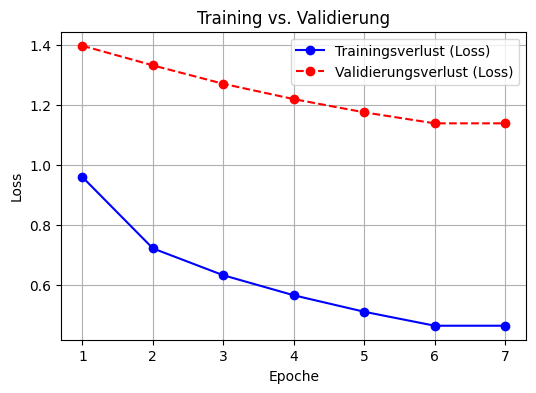

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1s 943us/step
709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step
Iteration 0 - Error: 0.0558
Epoch 1/6


c:\Users\Patrick R\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 



2115/2115 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 1.0927 - mae: 0.4020 - val_loss: 1.3941 - val_mae: 0.7870
Epoch 2/6
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.7692 - mae: 0.1676 - val_loss: 1.3359 - val_mae: 0.8030
Epoch 3/6
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6683 - mae: 0.1391 - val_loss: 1.2739 - val_mae: 0.8025
Epoch 4/6
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5996 - mae: 0.1280 - val_loss: 1.2249 - val_mae: 0.8054
Epoch 5/6
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5384 - mae: 0.1203 - val_loss: 1.1812 - val_mae: 0.8065
Epoch 6/6
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4898 - mae: 0.1146 - val_loss: 1.1426 - val_mae: 0.8057


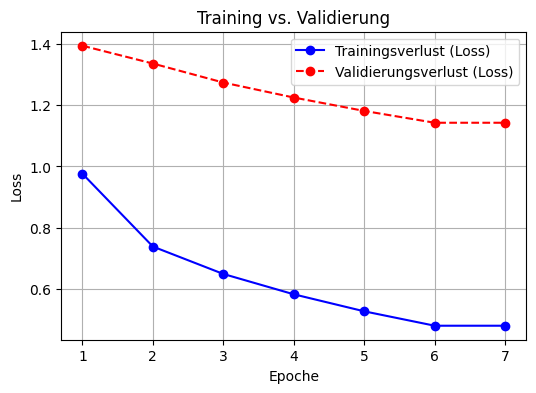

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1s 933us/step
709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 957us/step
Iteration 1 - Error: 0.0819


TrAdaBoostR2 Fortschritt:  50%|█████     | 1/2 [01:00<01:00, 60.71s/it]

Epoch 1/6


c:\Users\Patrick R\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 



2115/2115 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 1.0801 - mae: 0.4016 - val_loss: 1.3954 - val_mae: 0.7909
Epoch 2/6
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.7485 - mae: 0.1646 - val_loss: 1.3311 - val_mae: 0.8038
Epoch 3/6
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6484 - mae: 0.1377 - val_loss: 1.2680 - val_mae: 0.8038
Epoch 4/6
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5759 - mae: 0.1256 - val_loss: 1.2192 - val_mae: 0.8080
Epoch 5/6
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5187 - mae: 0.1192 - val_loss: 1.1738 - val_mae: 0.8074
Epoch 6/6
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.4692 - mae: 0.1128 - val_loss: 1.1379 - val_mae: 0.8097


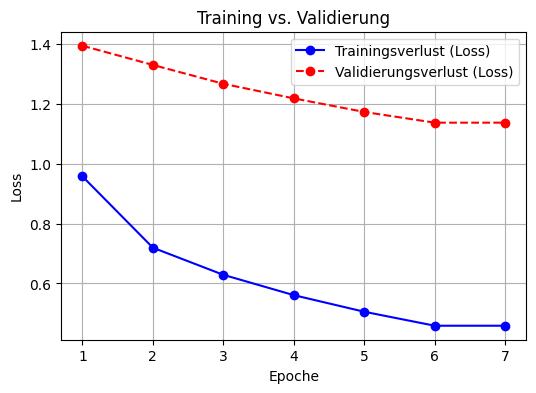

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1s 960us/step
709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 953us/step
Iteration 0 - Error: 0.0561
Epoch 1/6


c:\Users\Patrick R\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 



2115/2115 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 1.0924 - mae: 0.4018 - val_loss: 1.3980 - val_mae: 0.7913
Epoch 2/6
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7662 - mae: 0.1675 - val_loss: 1.3345 - val_mae: 0.8026
Epoch 3/6
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6659 - mae: 0.1380 - val_loss: 1.2761 - val_mae: 0.8043
Epoch 4/6
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5975 - mae: 0.1278 - val_loss: 1.2252 - val_mae: 0.8055
Epoch 5/6
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5427 - mae: 0.1205 - val_loss: 1.1813 - val_mae: 0.8057
Epoch 6/6
2115/2115 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4919 - mae: 0.1145 - val_loss: 1.1443 - val_mae: 0.8065


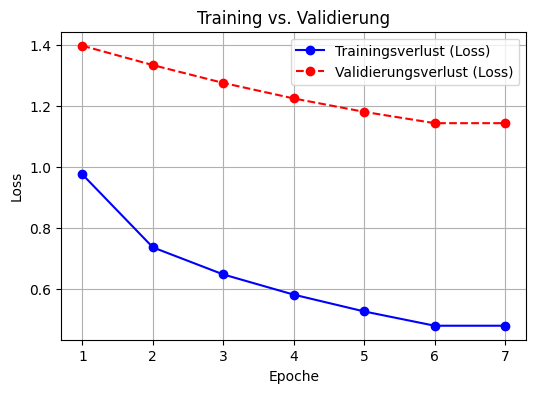

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1s 825us/step
709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 758us/step
Iteration 1 - Error: 0.0824


TrAdaBoostR2 Fortschritt: 100%|██████████| 2/2 [02:00<00:00, 60.10s/it]



 Training mit TrAdaBoostR2 beendet 



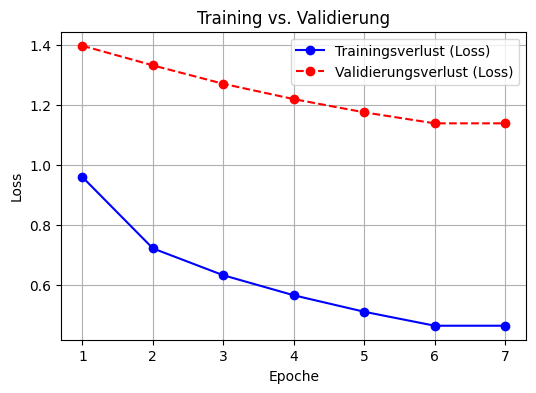

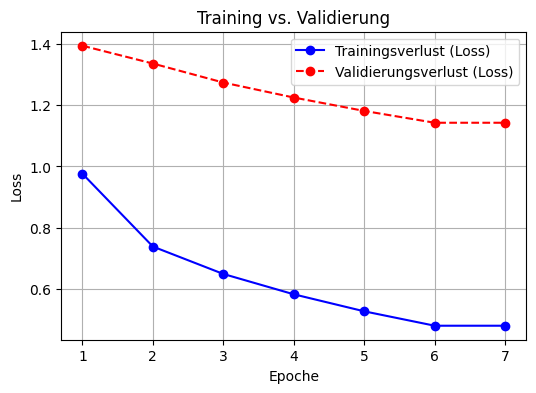

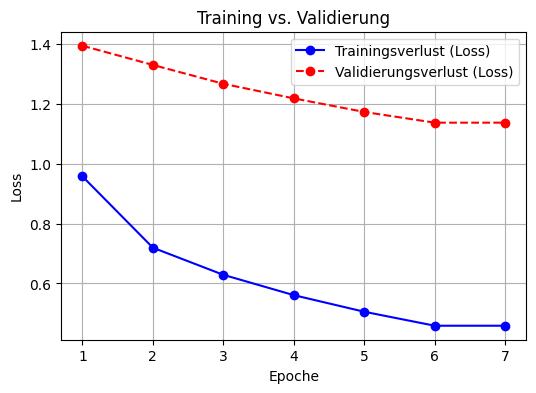

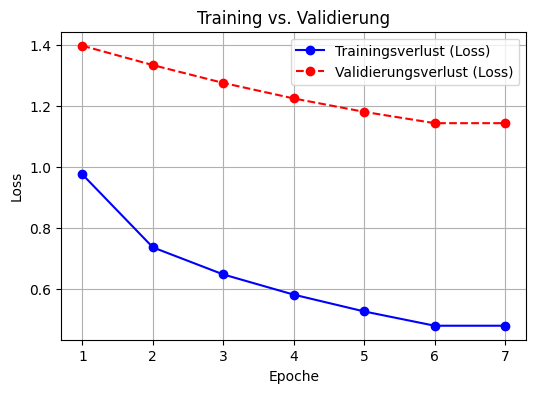

In [84]:
dateipfad_femDaten="build\\window_split\\sim_data_preprocessed\\1743966827\\"
dateipfad_realDaten="build\\window_split\\experiment-data-subset\\1743966820\\"
model_file = "assets\\tuned-synthetic-data-offset\\1742400473\\best-model.h5"
#model_file = "assets\\tuned-synthetic-data-offset\\1742239520\\cnn-synthetic-data-offset.h5"
#save_folder=r'build\tradaboost_model\test_training'
save_folder = os.path.join("build", "tradaboost_model", "training_03")
save_filename="training_03"

execute_tradaBoostR2_training(dateipfad_femDaten=dateipfad_femDaten,dateipfad_realDaten=dateipfad_realDaten,
                              model_file=model_file,save_folder=save_folder,save_filename=save_filename,n_estimators_tradaBoostR2=2,
                              learning_rate=0.000011858185678151421,epochs=6,batch_size=32,patience=1)

In [ ]:
dateipfad_femDaten="build\\window_split\\synthetic-data\\1742837410\\"
dateipfad_realDaten="build\\window_split\\real-data\\1742838313\\"
model_file = "assets\\tuned-synthetic-data-offset\\1742400473\\best-model.h5"
#model_file = "assets\\tuned-synthetic-data-offset\\1742239520\\cnn-synthetic-data-offset.h5"
#save_folder=r'build\tradaboost_model\test_training'
save_folder = os.path.join("build", "tradaboost_model", "training_02")
save_filename="training_02"

#Daten laden
X_source_scaled = NPY.from_file(dateipfad_femDaten + "x-train-scaled.npy").array
y_source_scaled = NPY.from_file(dateipfad_femDaten + "y-train-scaled.npy").array
X_source_scaled_Test = NPY.from_file(dateipfad_femDaten + "x-validate-scaled.npy").array
y_source_scaled_Test = NPY.from_file(dateipfad_femDaten + "y-validate-scaled.npy").array
X_target_scaled = NPY.from_file(dateipfad_realDaten + "x-train-scaled.npy").array
y_target_scaled = NPY.from_file(dateipfad_realDaten + "y-train-scaled.npy").array

# Modell erzeugen
cnn = CNN.from_file(model_file)
#cnn.model.summary()
outputs = cnn.model.outputs
combined_output = SparseStackLayer(name="sparse_output")(outputs)
new_model = tf.keras.Model(inputs=cnn.model.inputs, outputs=combined_output, name="extended_model")
live_plot_callback = LivePlotCallback()

new_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00011858185678151421), 
                loss="mean_absolute_error", 
                metrics=["mae"])#TODO Bruache ich diese Zeile?
early_stopping =keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
#csv_logger = CSVLogger(filename=os.path.join(save_folder, "training_log.csv"), separator=",", append=False)
csv_logger = CSVLogger(filename=os.path.join(save_folder, "training_log.csv"), separator=",", append=True)
cnn_wrapped = KerasRegressor(model=new_model, epochs=15, batch_size=32, verbose=1,callbacks=[early_stopping,csv_logger,live_plot_callback])

domainAdapt_tradaBoostR2_earlystopping(cnn_wrapped=cnn_wrapped,n_estimators_tradaBoostR2=9,
                                       X_source_scaled=X_source_scaled,y_source_scaled=y_source_scaled,
                                       X_target_scaled=X_target_scaled,y_target_scaled=y_target_scaled,
                                       X_source_scaled_Test=X_source_scaled_Test,y_source_scaled_Test=y_source_scaled_Test,
                                       save_folder=save_folder, save_filename=save_filename)




### **Validierung**

In [ ]:
trained_model_file = "build\\tradaboost_model\\training_01\\training_01.h5"
trained_model = CNN.from_file(trained_model_file)
X_target_val_scaled = NPY.from_file(dateipfad_realDaten + "x-test-scaled.npy").array
y_target_val_scaled = NPY.from_file(dateipfad_realDaten + "y-test-scaled.npy").array
print(f"X_target_val_scaled.shape = {X_target_val_scaled.shape}")
print(f"y_target_val_scaled.shape = {y_target_val_scaled.shape}")
y_target_val_scaled = np.squeeze(y_target_val_scaled)
print(f"y_target_val_scaled.shape = {y_target_val_scaled.shape}")

loss,error  = trained_model.model.evaluate(X_target_val_scaled,y_target_val_scaled, verbose=1)
print("Allgemeine Evaluation")
print(f"loss = {loss}")
print(f"error = {error}")


predictions = trained_model.model.predict(X_target_val_scaled)


Trainingsprocess von Tradaboost bewerten

In [ ]:
def eval_model(model, X_val, y_val):
    # Vorhersagen für die Validierungsdaten
    predictions = model.model.predict(X_val)

    error_X = np.abs(predictions[:, 0] - y_val[:, 0])  # Fehler für Verstellweg_X
    error_Y = np.abs(predictions[:, 1] - y_val[:, 1])  # Fehler für Verstellweg_Y
    error_Phi = np.abs(predictions[:, 2] - y_val[:, 2])  # Fehler für Verstellweg_Phi

    # Berechne den mittleren absoluten Fehler (MAE)
    mae_X = np.mean(error_X)
    mae_Y = np.mean(error_Y)
    mae_Phi = np.mean(error_Phi)

    # Berechne den mittleren quadratischen Fehler (MSE)
    mse_X = np.mean((predictions[:, 0] - y_val[:, 0]) ** 2)
    mse_Y = np.mean((predictions[:, 1] - y_val[:, 1]) ** 2)
    mse_Phi = np.mean((predictions[:, 2] - y_val[:, 2]) ** 2)

    # Berechne die Quadratwurzel des mittleren quadratischen Fehlers (RMSE)
    rmse_X = np.sqrt(mse_X)
    rmse_Y = np.sqrt(mse_Y)
    rmse_Phi = np.sqrt(mse_Phi)

    # Erstelle ein DataFrame für die Ergebnisse
    results = {
        'Metrik': ['MAE', 'MSE', 'RMSE'],
        'Verstellweg_X': [mae_X, mse_X, rmse_X],
        'Verstellweg_Y': [mae_Y, mse_Y, rmse_Y],
        'Verstellweg_Phi': [mae_Phi, mse_Phi, rmse_Phi]
    }
    return results



In [ ]:
#Durchgehen aller Modelle aus savefolder und evaluieren
errors = []
for filename in os.listdir(save_folder):
    if filename.startswith("tradaboost_model_iter_") and filename.endswith(".h5"):
        model_path = os.path.join(save_folder, filename)
        trained_model = CNN.from_file(trained_model_file)
        error=eval_model(trained_model, X_target_val_scaled, y_target_val_scaled)
        errors.append(error)
       

In [ ]:
print(errors)
#show(pd.DataFrame(errors))

# Die Metriken, die wir verwenden
metrics = ['MAE', 'MSE', 'RMSE']

# Die Verstellwege
verstellweg_labels = ['Verstellweg_X', 'Verstellweg_Y', 'Verstellweg_Phi']

# Erstelle das Plot-Grid (3 Zeilen, 3 Spalten)
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# Durchlaufe die Metriken und Verstellwege
for row, verstellweg in enumerate(verstellweg_labels):
    for col, metric in enumerate(metrics):
        # Extrahiere die Daten für die aktuelle Metrik und den Verstellweg
        data_values = [entry[verstellweg][col] for entry in errors]
        
        # Plotten
        ax = axes[row, col]
        ax.plot(range(len(data_values)), data_values, marker='o', label=metric)
        ax.set_title(f"{verstellweg} - {metric}")
        ax.set_xlabel('Modelle')
        ax.set_ylabel('Fehler')
        ax.grid(True)

# Layout anpassen
plt.tight_layout()
plt.show()